## 폐렴 진단기 성능개선
### Chest_X-ray
***
#### Step 1. 실험환경 Set-up
거의 바꿔볼 수 있을게 없을 것 같지만, Batch size, Epoch 등을 변경해볼 수 있을 것입니다.  

#### Step 2. 데이터 준비하기
원본 데이터를 가져와서 전처리 및 배치 구성을 진행합니다.  
의료영상 이미지의 특성상 데이터는 언제나 충분하지 않습니다. 이를 극복할 수 있는 방법을 고민해 봅시다.  

이전 실습에서 고려하지 않았던 augmentation 기법을 고려해 볼 수 있을 것입니다. 그러나 의료영상인 경우, 일반적인 이미지처리에서 사용하는 augmentation들이 항상 도움이 된다고 말할 수 없습니다. 특히 X-RAY 같은 의료영상의 특성상, 육안으로도 구분하기 어려운 미묘한 차이에 더해진 노이즈 등 부수효과가 오히려 방해를 줄 수도 있기 때문입니다.  
그래서 augmentation 도입은 신중해야 합니다.  

만약 예를 들어 좌우반전 정도의 augmentation만 도입한다고 한다면 다음과 같이 진행될 것입니다.  

#### Step 3. 데이터 시각화
학습용 데이터를 시각화해서 확인해 봅니다.
만약 augmentation을 시도했다면 이후 실습코드에 있는 show_batch() 함수를 통해 실제로 좌우반전 등이 제대로 처리되었는지 확인해 봅시다.

#### Step 4. CNN 모델링
의료영상 판독을 위해 실습에서 구현했던 model에서 다양한 것들을 바꾸어 가며 실험해볼 수 있습니다.  
Convolution filter, 채널 개수, activation, 모델구조 등을 다양하게 바꾸어볼 수 있습니다.  

그리고, 우리는 BatchNormalization과 Dropout을 한 모델 안에서 동시에 사용하는 특이한 구성을 실습했습니다.  
이것은 일반적으로 잘 사용되는 형태는 아닙니다.  
하지만 이미지 사이즈가 크고 데이터가 부족한 의료영상에서는 실용적으로 간혹 좋은 성능을 보이기도 합니다.  
만약 이 구성을 변경해 보면 어떤 효과가 발생하는지도 실험해 봅시다.  
BatchNormalization을 쓰거나 혹은 쓰지 않거나, Dropout을 쓰거나 혹은 쓰지 않거나 할 수 있습니다. 또, Dropout 비율을 변경해볼 수도 있습니다.  

#### Step 5. 데이터 imbalance 처리
실습코드에서 데이터의 imbalance 문제에 대처하기 위해 데이터 비율로 나누어진 class_weight를 설정해 주었습니다.   
만약 이러한 처리를 생략한다면 어떻게 될까요?  
또 recall을 강조하기 위해 폐렴데이터를 잘 맞추는 것을 더 강화하는 효과를 만들어낼 수는 없을까요?  

#### Step 6. 모델 훈련
loss 함수를 변경하기는 어렵겠지만, optimizer나 learning rate 등의 변화를 고려해볼 수 있을 것입니다.  

#### Step 7. 결과 확인과 시각화
테스트데이터로 훈련된 모델을 평가해 봅시다.  
우선은 accuracy를 고려해야겠지만 의료영상 모델의 특성상 recall도 중요합니다.  
훈련과정의 history 그래프를 시각화해 보고, 학습 진행양상을 면밀히 분석해 보는 것도 잊지 않도록 합시다.  
***
#### 평가문항
**1. 의료영상을 처리하는 CNN 기반 딥러닝 모델이 잘 구현되었다.**  
-모델 학습이 안정적으로 수렴하는 것을 시각화를 통해 확인하였다.  

**2. 데이터 준비, 모델구성 등의 과정의 다양한 실험이 체계적으로 수행되었다.**  
-regularization, augmentation 등의 기법의 사용 여부에 따른 모델 성능 측정이 ablation study 형태로 체계적으로 수행되었다.  

**3. 실습코드를 잘 개선하여 폐렴 검출 정확도가 추가로 향상되었다.**  
-Accuracy 기준 85%에 도달하였다.
***
#### Step 1. 실험환경 Set-up
**-필요한 라이브러리 가져오기**
***

In [1]:
import re    # 정규표현식 관련된 작업에 필요한 패키지
import os    # I/O 관련된 작업에 필요한 패키지 
import pandas as pd     # 데이터 전처리 관련된 작업에 필요한 패키지
import numpy as np      # 데이터 array 작업에 필요한 패키지
import tensorflow as tf  # 딥러닝 관련된 작업에 필요한 패키지
import matplotlib.pyplot as plt    # 데이터 시각화에 관련된 작업에 필요한 패키지
from sklearn.model_selection import train_test_split  # 데이터 전처리에 필요한 패키지

In [2]:
# 필요한 변수들 생성
# 데이터 로드할 때 빠르게 로드할 수 있도록하는 설정 변수
AUTOTUNE = tf.data.experimental.AUTOTUNE

# 데이터 ROOT 경로 변수
ROOT_PATH = os.path.join(os.getenv('HOME'), 'aiffel')

# BATCH_SIZE 변수
BATCH_SIZE = 16

# X-RAY 이미지 사이즈 변수
IMAGE_SIZE = [180, 180]

# EPOCH 크기 변수
EPOCHS = 25

print(ROOT_PATH)

/home/aiffel/aiffel


***
#### Step 2. 데이터 준비하기
**-데이터 가져오기**
***

In [3]:
train_filenames = tf.io.gfile.glob(str(ROOT_PATH + '/chest_xray/train/*/*'))
test_filenames = tf.io.gfile.glob(str(ROOT_PATH + '/chest_xray/test/*/*'))
val_filenames = tf.io.gfile.glob(str(ROOT_PATH + '/chest_xray/val/*/*'))

print(len(train_filenames))
print(len(test_filenames))
print(len(val_filenames))

5216
624
16


train data : 5216 (89%)
test data : 624 (10.7%)
val data : 16 (0.3%)
val data 갯수가 너무 적기때문에 비율을 조정하여 train data와의 비율을 80:20으로 맞추겠습니다.

In [4]:
filenames = tf.io.gfile.glob(str(ROOT_PATH + '/chest_xray/train/*/*'))
filenames.extend(tf.io.gfile.glob(str(ROOT_PATH + '/chest_xray/val/*/*')))

# train, test(val) dataset으로 분할. test_size에 0.2는 20%롤 의미함.
train_filenames, val_filenames = train_test_split(filenames, test_size=0.2)

print(len(train_filenames))
print(len(val_filenames))

4185
1047


In [5]:
COUNT_NORMAL = len([filename for filename in train_filenames if "NORMAL" in filename])
print("Normal images count in training set: " + str(COUNT_NORMAL))

COUNT_PNEUMONIA = len([filename for filename in train_filenames if "PNEUMONIA" in filename])
print("Pneumonia images count in training set: " + str(COUNT_PNEUMONIA))

Normal images count in training set: 1052
Pneumonia images count in training set: 3133


train data 안의 정상 이미지 수와 폐렴 이미지 수를 확인해 보았습니다.  
총 4185개의 data에서 정상 이미지 수는 1107개 폐렴 이미지 수는 3078개 입니다.  

In [6]:
train_list_ds = tf.data.Dataset.from_tensor_slices(train_filenames)
val_list_ds = tf.data.Dataset.from_tensor_slices(val_filenames)

tf.data.Dataset.from_tensor_slices()를 활용하여 dataset을 만들어 줍니다.  

In [7]:
TRAIN_IMG_COUNT = tf.data.experimental.cardinality(train_list_ds).numpy()
print("Training images count: " + str(TRAIN_IMG_COUNT))

VAL_IMG_COUNT = tf.data.experimental.cardinality(val_list_ds).numpy()
print("Validating images count: " + str(VAL_IMG_COUNT))

CLASS_NAMES = np.array([str(tf.strings.split(item, os.path.sep)[-1].numpy())[2:-1]
                        for item in tf.io.gfile.glob(str(ROOT_PATH + "/chest_xray/train/*"))])
print(CLASS_NAMES)

Training images count: 4185
Validating images count: 1047
['PNEUMONIA' 'NORMAL']


위에서 만든 data set이 잘 만들어졌는지 확인해보았습니다.

In [8]:
# 이미지에는 라벨이 없으므로 이미지 제목을 이용하여 라벨 데이터를 만들어줍니다.
def get_label(file_path):
    parts = tf.strings.split(file_path, os.path.sep)
    return parts[-2] == "PNEUMONIA"   # 폐렴이면 양성(True), 노말이면 음성(False)를 리턴하게 합니다.

현재 이미지에는 라벨 데이터가 별도로 존재하지 않으므로,  
이미지의 제목을 활용하여 라벨데이터를 만들어 주는 함수를 만들었습니다.
이미지의 제목이 폐렴이면 양성(True), 노말이면 음성(False)를 리턴하게 하였습니다.

In [9]:
def decode_img(img):
  # 이미지를 uint8 tensor로 바꾼다.
  img = tf.image.decode_jpeg(img, channels=3)
  # img를 범위 [0,1]의 float32 데이터 타입으로 바꾼다.
  img = tf.image.convert_image_dtype(img, tf.float32)
  # img의 이미지 사이즈를 IMAGE_SIZE에서 지정한 사이즈로 수정한다.
  return tf.image.resize(img, IMAGE_SIZE)

def process_path(file_path):
    label = get_label(file_path)
    img = tf.io.read_file(file_path)
    img = decode_img(img)
    return img, label

이미지 데이터의 크기가 제각각일 가능성을 고려하여,  
이미지 사이즈를 통일시킬 합수를 만들었습니다.  

In [10]:
train_ds = train_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)
val_ds = val_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)

위에서 만들어놓은 함수를 활용하여 데이터셋을 만들어줍니다.

In [11]:
for image, label in train_ds.take(3):
    print("Image shape: ", image.numpy().shape)
    print("Label: ", label.numpy())

Image shape:  (180, 180, 3)
Label:  True
Image shape:  (180, 180, 3)
Label:  True
Image shape:  (180, 180, 3)
Label:  True


이미지의 크기과 label이 잘 형성 되었음을 확인하였습니다.  
test data에도 마찬가지의 작업을 진행합니다.

In [12]:
test_list_ds = tf.data.Dataset.list_files(str(ROOT_PATH + '/chest_xray/test/*/*'))
TEST_IMAGE_COUNT = tf.data.experimental.cardinality(test_list_ds).numpy()
test_ds = test_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)
test_ds = test_ds.batch(BATCH_SIZE)

print(TEST_IMAGE_COUNT)

624


In [13]:
def augment(image,label):
    image = tf.image.random_flip_left_right(image)  # 랜덤하게 좌우를 반전합니다.
    return image,label

def prepare_for_training(ds, shuffle_buffer_size=1000):
    # augment 적용 부분이 배치처리 함수에 추가되었습니다.
    ds = ds.map(
            augment,       # augment 함수 적용
            num_parallel_calls=2
        )

    ds = ds.shuffle(buffer_size=shuffle_buffer_size)

    ds = ds.repeat()

    ds = ds.batch(BATCH_SIZE)

    ds = ds.prefetch(buffer_size=AUTOTUNE)

    return ds

train_ds = prepare_for_training(train_ds)
val_ds = prepare_for_training(val_ds)

학습을 효율적으로 하기위한 함수를 만들어줍니다.  
의료영상 이미지의 데이터부족을 극복하기위해 augmentaion 기법을 적용하였습니다.

***
#### Step 3. 데이터 시각화
***

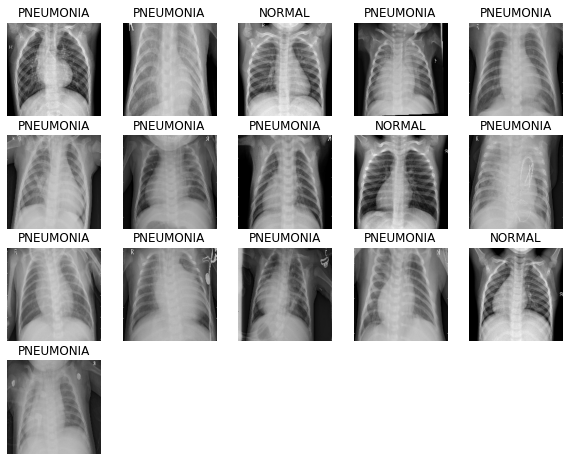

In [14]:
# 추출된 배치 사진을 보기위한 함수 만들기
image_batch, label_batch = next(iter(train_ds))

def show_batch(image_batch, label_batch):
    plt.figure(figsize=(10,10))
    for n in range(16):
        ax = plt.subplot(5,5,n+1)
        plt.imshow(image_batch[n])
        if label_batch[n]:
            plt.title("PNEUMONIA")
        else:
            plt.title("NORMAL")
        plt.axis("off")

show_batch(image_batch.numpy(), label_batch.numpy())

***
#### Step 4. CNN 모델링
***

In [15]:
# CNN 모델링을 위한 함수 만들기
def conv_block(filters):
    block = tf.keras.Sequential([
        tf.keras.layers.SeparableConv2D(filters, 3, activation='relu', padding='same'),
        tf.keras.layers.SeparableConv2D(filters, 3, activation='relu', padding='same'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPool2D()
    ]
    )
    
    return block

def dense_block(units, dropout_rate):
    block = tf.keras.Sequential([
        tf.keras.layers.Dense(units, activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(dropout_rate)
    ])
    
    return block

In [16]:
def build_model():
    model = tf.keras.Sequential([
        tf.keras.Input(shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3)),
        
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.MaxPool2D(),
        
        conv_block(32),
        conv_block(64),
        
        conv_block(128),
        tf.keras.layers.Dropout(0.2),
        
        conv_block(256),
        tf.keras.layers.Dropout(0.2),
        
        tf.keras.layers.Flatten(),
        dense_block(512, 0.7),
        dense_block(128, 0.5),
        dense_block(64, 0.3),
        
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])
    
    return model

***
#### Step 5. 데이터 imbalance 처리
***

In [17]:
weight_for_0 = (1 / COUNT_NORMAL)*(TRAIN_IMG_COUNT)/2.0 
weight_for_1 = (1 / COUNT_PNEUMONIA)*(TRAIN_IMG_COUNT)/2.0

class_weight = {0: weight_for_0, 1: weight_for_1}

print('Weight for class 0: {:.2f}'.format(weight_for_0))
print('Weight for class 1: {:.2f}'.format(weight_for_1))

Weight for class 0: 1.99
Weight for class 1: 0.67


***
#### Step 6. 모델 훈련
***

In [18]:
with tf.device('/GPU:0'):
    model = build_model()

    METRICS = [
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ]
    
    model.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=METRICS
    )

In [19]:
with tf.device('/GPU:0'):
    history = model.fit(
        train_ds,
        steps_per_epoch=TRAIN_IMG_COUNT // BATCH_SIZE,
        epochs=EPOCHS,
        validation_data=val_ds,
        validation_steps=VAL_IMG_COUNT // BATCH_SIZE,
        class_weight=class_weight,
    )

Epoch 1/25
261/261 [==============================] - 38s 147ms/step - loss: 0.4136 - accuracy: 0.8046 - precision: 0.9515 - recall: 0.7787 - val_loss: 0.6951 - val_accuracy: 0.7173 - val_precision: 0.7173 - val_recall: 1.0000
Epoch 2/25
261/261 [==============================] - 36s 136ms/step - loss: 0.2493 - accuracy: 0.9025 - precision: 0.9709 - recall: 0.8966 - val_loss: 1.4728 - val_accuracy: 0.7173 - val_precision: 0.7173 - val_recall: 1.0000
Epoch 3/25
261/261 [==============================] - 36s 137ms/step - loss: 0.2106 - accuracy: 0.9179 - precision: 0.9748 - recall: 0.9141 - val_loss: 0.5190 - val_accuracy: 0.7740 - val_precision: 0.7604 - val_recall: 1.0000
Epoch 4/25
261/261 [==============================] - 36s 137ms/step - loss: 0.1887 - accuracy: 0.9315 - precision: 0.9778 - recall: 0.9296 - val_loss: 0.2579 - val_accuracy: 0.9000 - val_precision: 0.9984 - val_recall: 0.8617
Epoch 5/25
261/261 [==============================] - 36s 138ms/step - loss: 0.1900 - accura

***
#### Step 7. 결과 확인과 시각화
***

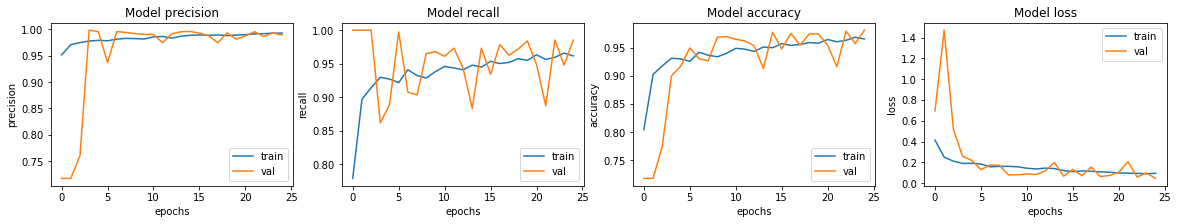

In [20]:
fig, ax = plt.subplots(1, 4, figsize=(20, 3))
ax = ax.ravel()

for i, met in enumerate(['precision', 'recall', 'accuracy', 'loss']):
    ax[i].plot(history.history[met])
    ax[i].plot(history.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

In [21]:
loss, acc, prec, rec = model.evaluate(test_ds)

39/39 [==============================] - 4s 101ms/step - loss: 0.8868 - accuracy: 0.7853 - precision: 0.7452 - recall: 0.9974


**아무것도 변경없이 baseline 그대로 진행했을시에,  
accuracy 기준 83.5%가 나왔습니다.  
아래의 Step8을 통해 여러가지 조건들을 변경하고 추가하면서  
모델의 정확도가 어떻게 바뀌는지 살펴보겠습니다.**
***
#### Step 8. Ablation study
**-위에서 데이터를 준비하는 과정에서 augmentation 기법을 고려해 볼 수 있다고 하였습니다.  
-그러나 개인적인 판단으로는 미세한 차이만을 유발시키는 데이터셋은 오히려 학습에 악영향을 끼칠 것으로 판단됩니다.  
-따라서 CNN모델의 변경이나, 하이퍼파라미터의 조절을 통해 accuracy를 높여보도록 하겠습니다.**
***
**1.CNN 모델링 변경**  
(1)conv_block내부의 레이어수 변경  
(2)build_model에서 conv_block의 층 수 변경  
(3)Dropout 계층 제외 시  
(4)dropout, batch normalization 계층 삭제
(5)augmentation 도입시
***
(1)conv_block내부의 레이어수 변경
> 2개에서 3개로 변경

In [22]:
# CNN 모델링을 위한 함수 만들기
def conv_block1(filters):
    block = tf.keras.Sequential([
        tf.keras.layers.SeparableConv2D(filters, 3, activation='relu', padding='same'),
        tf.keras.layers.SeparableConv2D(filters, 3, activation='relu', padding='same'),
        #기존 2개층이었던 필터레이어를 3개로 늘렸습니다.
        tf.keras.layers.SeparableConv2D(filters, 3, activation='relu', padding='same'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPool2D()
    ]
    )
    
    return block

def dense_block(units, dropout_rate):
    block = tf.keras.Sequential([
        tf.keras.layers.Dense(units, activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(dropout_rate)
    ])
    
    return block

In [23]:
def build_model1():
    model1 = tf.keras.Sequential([
        tf.keras.Input(shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3)),
        
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.MaxPool2D(),
        
        conv_block1(32),
        conv_block1(64),
        
        conv_block1(128),
        tf.keras.layers.Dropout(0.2),
        
        conv_block1(256),
        tf.keras.layers.Dropout(0.2),
        
        tf.keras.layers.Flatten(),
        dense_block(512, 0.7),
        dense_block(128, 0.5),
        dense_block(64, 0.3),

        tf.keras.layers.Dense(1, activation='sigmoid')
    ])
    
    return model1

In [24]:
with tf.device('/GPU:0'):
    model1 = build_model1()

    METRICS = [
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ]
    
    model1.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=METRICS
    )

In [25]:
with tf.device('/GPU:0'):
    history = model1.fit(
        train_ds,
        steps_per_epoch=TRAIN_IMG_COUNT // BATCH_SIZE,
        epochs=EPOCHS,
        validation_data=val_ds,
        validation_steps=VAL_IMG_COUNT // BATCH_SIZE,
        class_weight=class_weight,
    )

Epoch 1/25
261/261 [==============================] - 38s 146ms/step - loss: 0.7887 - accuracy: 0.5524 - precision: 0.7944 - recall: 0.5425 - val_loss: 0.9859 - val_accuracy: 0.2837 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 2/25
261/261 [==============================] - 38s 144ms/step - loss: 0.4106 - accuracy: 0.7874 - precision: 0.9538 - recall: 0.7525 - val_loss: 1.2157 - val_accuracy: 0.7154 - val_precision: 0.7154 - val_recall: 1.0000
Epoch 3/25
261/261 [==============================] - 38s 144ms/step - loss: 0.2867 - accuracy: 0.8788 - precision: 0.9652 - recall: 0.8695 - val_loss: 0.9436 - val_accuracy: 0.7163 - val_precision: 0.7163 - val_recall: 1.0000
Epoch 4/25
261/261 [==============================] - 37s 143ms/step - loss: 0.2331 - accuracy: 0.9112 - precision: 0.9752 - recall: 0.9044 - val_loss: 0.2536 - val_accuracy: 0.9029 - val_precision: 0.9969 - val_recall: 0.8673
Epoch 5/25
261/261 [==============================] - 35s 135ms/step - loss: 0.2079 

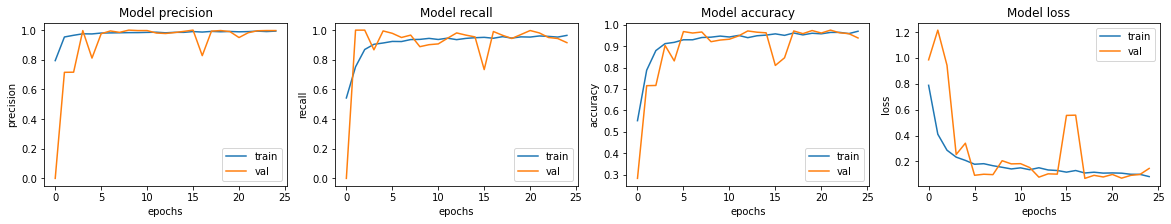

In [26]:
fig, ax = plt.subplots(1, 4, figsize=(20, 3))
ax = ax.ravel()

for i, met in enumerate(['precision', 'recall', 'accuracy', 'loss']):
    ax[i].plot(history.history[met])
    ax[i].plot(history.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

In [27]:
loss, acc, prec, rec = model1.evaluate(test_ds)

39/39 [==============================] - 4s 90ms/step - loss: 0.5561 - accuracy: 0.8365 - precision: 0.8214 - recall: 0.9436


2개에서 3개로 변경했을때는 accuracy기준으로 85% 이상을 달성했음을 확인하였습니다.  
그럼 4개로 늘렸을 때는 더 accuracy가 높아지는지 확인해보겠습니다.
***
(1)conv_block내부의 레이어수 변경
> 2개에서 4개로 변경

In [28]:
# CNN 모델링을 위한 함수 만들기
def conv_block2(filters):
    block = tf.keras.Sequential([
        tf.keras.layers.SeparableConv2D(filters, 3, activation='relu', padding='same'),
        tf.keras.layers.SeparableConv2D(filters, 3, activation='relu', padding='same'),
        #기존 2개층이었던 필터레이어를 4개로 늘렸습니다.
        tf.keras.layers.SeparableConv2D(filters, 3, activation='relu', padding='same'),
        tf.keras.layers.SeparableConv2D(filters, 3, activation='relu', padding='same'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPool2D()
    ]
    )
    
    return block

def dense_block(units, dropout_rate):
    block = tf.keras.Sequential([
        tf.keras.layers.Dense(units, activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(dropout_rate)
    ])
    
    return block

In [29]:
def build_model2():
    model2 = tf.keras.Sequential([
        tf.keras.Input(shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3)),
        
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.MaxPool2D(),
        
        conv_block2(32),
        conv_block2(64),
        
        conv_block2(128),
        tf.keras.layers.Dropout(0.2),
        
        conv_block2(256),
        tf.keras.layers.Dropout(0.2),
        
        tf.keras.layers.Flatten(),
        dense_block(512, 0.7),
        dense_block(128, 0.5),
        dense_block(64, 0.3),

        tf.keras.layers.Dense(1, activation='sigmoid')
    ])
    
    return model2

In [30]:
with tf.device('/GPU:0'):
    model2 = build_model2()

    METRICS = [
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ]
    
    model2.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=METRICS
    )

In [ ]:
with tf.device('/GPU:0'):
    history = model2.fit(
        train_ds,
        steps_per_epoch=TRAIN_IMG_COUNT // BATCH_SIZE,
        epochs=EPOCHS,
        validation_data=val_ds,
        validation_steps=VAL_IMG_COUNT // BATCH_SIZE,
        class_weight=class_weight,
    )

Epoch 1/25
261/261 [==============================] - 38s 144ms/step - loss: 0.8812 - accuracy: 0.5031 - precision: 0.7496 - recall: 0.5048 - val_loss: 0.8235 - val_accuracy: 0.2817 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 2/25
261/261 [==============================] - 37s 143ms/step - loss: 0.7891 - accuracy: 0.5000 - precision: 0.7500 - recall: 0.4994 - val_loss: 0.7697 - val_accuracy: 0.2837 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 3/25
261/261 [==============================] - 38s 144ms/step - loss: 0.7536 - accuracy: 0.4974 - precision: 0.7409 - recall: 0.5038 - val_loss: 0.7010 - val_accuracy: 0.2837 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 4/25
261/261 [==============================] - 33s 126ms/step - loss: 0.7240 - accuracy: 0.5062 - precision: 0.7537 - recall: 0.5046 - val_loss: 0.6315 - val_accuracy: 0.7173 - val_precision: 0.7173 - val_recall: 1.0000
Epoch 5/25
261/261 [==============================] - 44s 168ms/step

In [ ]:
fig, ax = plt.subplots(1, 4, figsize=(20, 3))
ax = ax.ravel()

for i, met in enumerate(['precision', 'recall', 'accuracy', 'loss']):
    ax[i].plot(history.history[met])
    ax[i].plot(history.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

In [ ]:
loss, acc, prec, rec = model2.evaluate(test_ds)

3개로 늘렸을 때에는 증가했던 accuracy가 4개로 늘렸을 때는 오히려 학습에 방해가 되는 느낌이었습니다.  
더이상 레이어수를 늘리는 것은 의미가 없어보입니다.  
따라서 **conv_block내부의 레이어수**는 **3개**로 결정하는게 나은 판단으로 보입니다.
***
(2)build_model에서 conv_block의 층 수 변경
> conv_block의 층 1층 추가

In [ ]:
# CNN 모델링을 위한 함수 만들기
def conv_block(filters):
    block = tf.keras.Sequential([
        tf.keras.layers.SeparableConv2D(filters, 3, activation='relu', padding='same'),
        tf.keras.layers.SeparableConv2D(filters, 3, activation='relu', padding='same'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPool2D()
    ]
    )
    
    return block

def dense_block(units, dropout_rate):
    block = tf.keras.Sequential([
        tf.keras.layers.Dense(units, activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(dropout_rate)
    ])
    
    return block

In [ ]:
def build_model3():
    model3 = tf.keras.Sequential([
        tf.keras.Input(shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3)),
        
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.MaxPool2D(),
        
        conv_block(32),
        conv_block(64),
        
        conv_block(128),
        tf.keras.layers.Dropout(0.2),
        
        conv_block(256),
        tf.keras.layers.Dropout(0.2),

        # conv_block을 하나 추가해보았습니다.
        conv_block(512),
        tf.keras.layers.Dropout(0.2),
        
        tf.keras.layers.Flatten(),
        dense_block(512, 0.7),
        dense_block(128, 0.5),
        dense_block(64, 0.3),

        tf.keras.layers.Dense(1, activation='sigmoid')
    ])
    
    return model3

In [ ]:
with tf.device('/GPU:0'):
    model3 = build_model3()

    METRICS = [
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ]
    
    model3.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=METRICS
    )

In [ ]:
with tf.device('/GPU:0'):
    history = model3.fit(
        train_ds,
        steps_per_epoch=TRAIN_IMG_COUNT // BATCH_SIZE,
        epochs=EPOCHS,
        validation_data=val_ds,
        validation_steps=VAL_IMG_COUNT // BATCH_SIZE,
        class_weight=class_weight,
    )

In [ ]:
loss, acc, prec, rec = model3.evaluate(test_ds)

단순히 conv_block의 층 1층 추가 한다고 해서 성능이 눈에띄게 좋아지는 것이 아니라는 것을 확인하였습니다.  
그래도 성능은 좋아지니 1층을 추가하는 것은 나쁘지 않은 방법이라고 판단됩니다.  
그럼 Dropout 계층을 제외한다면 어떻게 될지 확인해 보겠습니다. 
***
(3)Dropout 계층 제외 시 
***

In [ ]:
# CNN 모델링을 위한 함수 만들기
def conv_block(filters):
    block = tf.keras.Sequential([
        tf.keras.layers.SeparableConv2D(filters, 3, activation='relu', padding='same'),
        tf.keras.layers.SeparableConv2D(filters, 3, activation='relu', padding='same'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPool2D()
    ]
    )
    
    return block

def dense_block(units):#, dropout_rate
    block = tf.keras.Sequential([
        tf.keras.layers.Dense(units, activation='relu'),
        tf.keras.layers.BatchNormalization(),
        # tf.keras.layers.Dropout(dropout_rate)
    ])
    
    return block

In [ ]:
def build_model4():
    model4 = tf.keras.Sequential([
        tf.keras.Input(shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3)),
        
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.MaxPool2D(),
        
        conv_block(32),
        conv_block(64),
        
        conv_block(128),
        #tf.keras.layers.Dropout(0.2),
        
        conv_block(256),
        #tf.keras.layers.Dropout(0.2),
        
        tf.keras.layers.Flatten(),
        dense_block(512),#, 0.7
        dense_block(128),#, 0.5
        dense_block(64),#, 0.3

        tf.keras.layers.Dense(1, activation='sigmoid')
    ])
    
    return model4

In [ ]:
with tf.device('/GPU:0'):
    model4 = build_model4()

    METRICS = [
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ]
    
    model4.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=METRICS
    )

In [ ]:
with tf.device('/GPU:0'):
    history = model4.fit(
        train_ds,
        steps_per_epoch=TRAIN_IMG_COUNT // BATCH_SIZE,
        epochs=EPOCHS,
        validation_data=val_ds,
        validation_steps=VAL_IMG_COUNT // BATCH_SIZE,
        class_weight=class_weight,
    )

In [ ]:
loss, acc, prec, rec = model4.evaluate(test_ds)

dropout을 전부 제외하였을 경우에는 accuracy가 오히려 낮아지는 것을 확인하였습니다.  
이를 통해 dropout은 필요하다고 판단됩니다.  
그런데 만약 dropout과 normalizatioin이 둘다 없다면 어떻게 될까요?  
한번 확인해 보겠습니다.  
***
(4)dropout, batch normalization 계층 삭제
***

In [ ]:
# CNN 모델링을 위한 함수 만들기
def conv_block2(filters):
    block2 = tf.keras.Sequential([
        tf.keras.layers.SeparableConv2D(filters, 3, activation='relu', padding='same'),
        tf.keras.layers.SeparableConv2D(filters, 3, activation='relu', padding='same'),
        # tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPool2D()
    ]
    )
    
    return block2

def dense_block2(units):#, dropout_rate
    block2 = tf.keras.Sequential([
        tf.keras.layers.Dense(units, activation='relu'),
        # tf.keras.layers.BatchNormalization(),
        # tf.keras.layers.Dropout(dropout_rate)
    ])
    
    return block2

In [ ]:
def build_model5():
    model5 = tf.keras.Sequential([
        tf.keras.Input(shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3)),
        
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.MaxPool2D(),
        
        conv_block2(32),
        conv_block2(64),
        
        conv_block2(128),
        tf.keras.layers.Dropout(0.2),
        
        conv_block2(256),
        tf.keras.layers.Dropout(0.2),
        
        tf.keras.layers.Flatten(),
        dense_block2(512),#, 0.7
        dense_block2(128),#, 0.5
        dense_block2(64),#, 0.3

        tf.keras.layers.Dense(1, activation='sigmoid')
    ])
    
    return model5

In [ ]:
with tf.device('/GPU:0'):
    model5 = build_model5()

    METRICS = [
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ]
    
    model5.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=METRICS
    )

In [ ]:
loss, acc, prec, rec = model5.evaluate(test_ds)

처참하게 떨어져 버렸습니다.  
결과적으로는 conv_block함수 내부의 필터레이어를 3개로 하고,  
conv_block 층을 1~2개정도 추가하고,  
dropout과 batch normalization 둘다 유지하는게 성능향상에 도움이 될 것 같습니다.
추가적으로 최종 모델을 만들기전에 데이터에도 추가적인 처리를 하였을 때,  
기본모델에서의 accuracy가 어떻게 변하는지 확인해 보겠습니다.
***
(5)augmentation 도입시
***

In [ ]:
def augment(image,label):
    image = tf.image.random_flip_left_right(image)  # 랜덤하게 좌우를 반전합니다.
    return image,label

def prepare_for_training(ds, shuffle_buffer_size=1000):
    # augment 적용 부분이 배치처리 함수에 추가되었습니다.
    ds = ds.map(
            augment,       # augment 함수 적용
            num_parallel_calls=2
        )

    ds = ds.shuffle(buffer_size=shuffle_buffer_size)

    ds = ds.repeat()

    ds = ds.batch(BATCH_SIZE)

    ds = ds.prefetch(buffer_size=AUTOTUNE)

    return ds

train_ds = prepare_for_training(train_ds)
val_ds = prepare_for_training(val_ds)

In [ ]:
# CNN 모델링을 위한 함수 만들기
def conv_block(filters):
    block = tf.keras.Sequential([
        tf.keras.layers.SeparableConv2D(filters, 3, activation='relu', padding='same'),
        tf.keras.layers.SeparableConv2D(filters, 3, activation='relu', padding='same'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPool2D()
    ]
    )
    
    return block

def dense_block(units, dropout_rate):
    block = tf.keras.Sequential([
        tf.keras.layers.Dense(units, activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(dropout_rate)
    ])
    
    return block

In [ ]:
def build_model():
    model = tf.keras.Sequential([
        tf.keras.Input(shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3)),
        
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.MaxPool2D(),
        
        conv_block(32),
        conv_block(64),
        
        conv_block(128),
        tf.keras.layers.Dropout(0.2),
        
        conv_block(256),
        tf.keras.layers.Dropout(0.2),
        
        tf.keras.layers.Flatten(),
        dense_block(512, 0.7),
        dense_block(128, 0.5),
        dense_block(64, 0.3),
        
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])
    
    return model

In [ ]:
weight_for_0 = (1 / COUNT_NORMAL)*(TRAIN_IMG_COUNT)/2.0 
weight_for_1 = (1 / COUNT_PNEUMONIA)*(TRAIN_IMG_COUNT)/2.0

class_weight = {0: weight_for_0, 1: weight_for_1}

print('Weight for class 0: {:.2f}'.format(weight_for_0))
print('Weight for class 1: {:.2f}'.format(weight_for_1))

In [ ]:
with tf.device('/GPU:0'):
    model = build_model()

    METRICS = [
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ]
    
    model.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=METRICS
    )

In [ ]:
with tf.device('/GPU:0'):
    history = model.fit(
        train_ds,
        steps_per_epoch=TRAIN_IMG_COUNT // BATCH_SIZE,
        epochs=EPOCHS,
        validation_data=val_ds,
        validation_steps=VAL_IMG_COUNT // BATCH_SIZE,
        class_weight=class_weight,
    )

In [ ]:
loss, acc, prec, rec = model.evaluate(test_ds)

(3)마지막 활성화함수 변경  
(4)Drop out 여부
***

#### Step 1. 실험환경 Set-up
거의 바꿔볼 수 있을게 없을 것 같지만, Batch size, Epoch 등을 변경해볼 수 있을 것입니다.  

#### Step 2. 데이터 준비하기
원본 데이터를 가져와서 전처리 및 배치 구성을 진행합니다.  
의료영상 이미지의 특성상 데이터는 언제나 충분하지 않습니다. 이를 극복할 수 있는 방법을 고민해 봅시다.  

이전 실습에서 고려하지 않았던 augmentation 기법을 고려해 볼 수 있을 것입니다. 그러나 의료영상인 경우, 일반적인 이미지처리에서 사용하는 augmentation들이 항상 도움이 된다고 말할 수 없습니다. 특히 X-RAY 같은 의료영상의 특성상, 육안으로도 구분하기 어려운 미묘한 차이에 더해진 노이즈 등 부수효과가 오히려 방해를 줄 수도 있기 때문입니다.  
그래서 augmentation 도입은 신중해야 합니다.  

만약 예를 들어 좌우반전 정도의 augmentation만 도입한다고 한다면 다음과 같이 진행될 것입니다.  

#### Step 3. 데이터 시각화
학습용 데이터를 시각화해서 확인해 봅니다.
만약 augmentation을 시도했다면 이후 실습코드에 있는 show_batch() 함수를 통해 실제로 좌우반전 등이 제대로 처리되었는지 확인해 봅시다.

#### Step 4. CNN 모델링
의료영상 판독을 위해 실습에서 구현했던 model에서 다양한 것들을 바꾸어 가며 실험해볼 수 있습니다.  
Convolution filter, 채널 개수, activation, 모델구조 등을 다양하게 바꾸어볼 수 있습니다.  

그리고, 우리는 BatchNormalization과 Dropout을 한 모델 안에서 동시에 사용하는 특이한 구성을 실습했습니다.  
이것은 일반적으로 잘 사용되는 형태는 아닙니다.  
하지만 이미지 사이즈가 크고 데이터가 부족한 의료영상에서는 실용적으로 간혹 좋은 성능을 보이기도 합니다.  
만약 이 구성을 변경해 보면 어떤 효과가 발생하는지도 실험해 봅시다.  
BatchNormalization을 쓰거나 혹은 쓰지 않거나, Dropout을 쓰거나 혹은 쓰지 않거나 할 수 있습니다. 또, Dropout 비율을 변경해볼 수도 있습니다.  

#### Step 5. 데이터 imbalance 처리
실습코드에서 데이터의 imbalance 문제에 대처하기 위해 데이터 비율로 나누어진 class_weight를 설정해 주었습니다.   
만약 이러한 처리를 생략한다면 어떻게 될까요?  
또 recall을 강조하기 위해 폐렴데이터를 잘 맞추는 것을 더 강화하는 효과를 만들어낼 수는 없을까요?  

#### Step 6. 모델 훈련
loss 함수를 변경하기는 어렵겠지만, optimizer나 learning rate 등의 변화를 고려해볼 수 있을 것입니다.  

#### Step 7. 결과 확인과 시각화
테스트데이터로 훈련된 모델을 평가해 봅시다.  
우선은 accuracy를 고려해야겠지만 의료영상 모델의 특성상 recall도 중요합니다.  
훈련과정의 history 그래프를 시각화해 보고, 학습 진행양상을 면밀히 분석해 보는 것도 잊지 않도록 합시다.  
***
#### 평가문항
**1. 의료영상을 처리하는 CNN 기반 딥러닝 모델이 잘 구현되었다.**  
-모델 학습이 안정적으로 수렴하는 것을 시각화를 통해 확인하였다.  

**2. 데이터 준비, 모델구성 등의 과정의 다양한 실험이 체계적으로 수행되었다.**  
-regularization, augmentation 등의 기법의 사용 여부에 따른 모델 성능 측정이 ablation study 형태로 체계적으로 수행되었다.  

**3. 실습코드를 잘 개선하여 폐렴 검출 정확도가 추가로 향상되었다.**  
-Accuracy 기준 85%에 도달하였다.